In [0]:
import numpy as np
import pandas as pd 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
import lightgbm as lgb

In [0]:
X_train = pd.read_csv('https://raw.githubusercontent.com/sengatang/udacity_ml_nano/master/MLND_FINAL_Rossman/sales%20data/train.csv', parse_dates=[2], low_memory=False)
X_test = pd.read_csv('https://raw.githubusercontent.com/sengatang/udacity_ml_nano/master/MLND_FINAL_Rossman/sales%20data/test.csv', parse_dates=[3], low_memory=False)
store = pd.read_csv('https://raw.githubusercontent.com/sengatang/udacity_ml_nano/master/MLND_FINAL_Rossman/sales%20data/store.csv')

In [0]:
def get_processed_data_with_store(df, store):
  # 1. merge store
  df = pd.merge(df, store, on="Store", how="left")
  df['Year'] = df['Date'].dt.year
  df['Month'] = df['Date'].dt.month
  df['Day'] = df['Date'].dt.day
  df['DayOfYear'] = df['Date'].dt.dayofyear
  df['WeekOfYear'] = df['Date'].dt.weekofyear
  df.drop("Date", axis=1, inplace=True)
  df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + \
          (df.Month - df.CompetitionOpenSinceMonth)
  df['CompetitionOpen'] = df.CompetitionOpen.apply(lambda x: x if x > 0 else 0)
  df['PromoOpen'] = 12 * (df.Year - df.Promo2SinceYear) + (df.WeekOfYear - df.Promo2SinceWeek) / 4.0
  df['PromoOpen'] = df['PromoOpen'].apply(lambda x: x if x > 0 else 0)
  month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
  df['IsPromoMonth'] = 0
  df['MonthStr'] = df.Month.map(month2str)
  for interval in df.PromoInterval.unique():
    if interval != '' and type(interval)==str:
        for month in interval.split(','):
            df.loc[(df.MonthStr == month) & (df.PromoInterval == interval), 'IsPromoMonth'] = 1
  df.drop('MonthStr', axis=1, inplace=True)
  return df

In [0]:
def add_feature(df):
  avg_sale_per_store = X_train[["Store", "Sales", "Customers"]].groupby("Store").sum()
  avg_sale_per_store["AvgSalePerStore"] = avg_sale_per_store["Sales"] / avg_sale_per_store["Customers"]
  avg_sale_per_store.drop(['Sales', 'Customers'], axis=1, inplace=True)
  df = pd.merge(df, avg_sale_per_store, how="left", on="Store")

  groups = X_train[["Store", "Open"]].groupby("Store").mean()
  groups.rename(columns={"Open":"ShopAvgOpen"}, inplace=True)
  df = pd.merge(df, groups, how="left", on="Store")

  groups1 = X_train[["Store", "Sales"]].groupby("Store").sum()
  groups2 = X_train[X_train["StateHoliday"] != "0"][["Store", "Sales"]].groupby("Store").sum()
  groups = pd.merge(groups1, groups2, on="Store")
  groups["HolidayShopSales"] = groups["Sales_y"] / groups["Sales_x"]
  groups.drop(["Sales_x", "Sales_y"], axis=1, inplace=True)
  df = pd.merge(df, groups, how="left", on="Store")

  groups1 = X_train[["Store", "Sales"]].groupby("Store").sum()
  groups2 = X_train[X_train["IsPromoMonth"] == 1][["Store", "Sales"]].groupby("Store").sum()
  groups = pd.merge(groups1, groups2, on="Store")
  groups["PromoShopSales"] = groups["Sales_y"] / groups["Sales_x"]
  groups.drop(["Sales_x", "Sales_y"], axis=1, inplace=True)
  df = pd.merge(df, groups, how="left", on="Store")
  return df

In [0]:
map_dict = {
  'a': 1,
  'b': 2,
  'c': 3,
  'd': 4,
  '0': 0,
  0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  'Jan,Apr,Jul,Oct': 1,
  'Feb,May,Aug,Nov': 2,
  'Mar,Jun,Sept,Dec': 3
}
X_train.sort_values(["Date"], inplace=True, kind="mergesort")
X_train.reset_index(drop=True, inplace=True)

X_test['Open'].unique()
X_test["Open"] = X_test['Open'].fillna(1) # 将缺失的值补充为 1

store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)
store.fillna(0, inplace = True)

X_train = get_processed_data_with_store(X_train, store)
X_test = get_processed_data_with_store(X_test, store)
X_train = add_feature(X_train)
X_test = add_feature(X_test)

test_close_ind = np.where(X_test["Open"] == 0)[0]
X_train = X_train[X_train["Sales"] != 0]
X_train.drop(["Open"], axis=1, inplace=True)
X_test.drop(["Open"], axis=1, inplace=True)

for col in ['StateHoliday', 'Assortment', 'PromoInterval', 'StoreType']:
  X_train[col] = X_train[col].map(map_dict)
  X_test[col] = X_test[col].map(map_dict)

y_train = np.array(X_train["Sales"])
X_train.drop("Sales", axis=1, inplace=True)
X_train.drop("Customers", axis=1, inplace=True)
test_ID = X_test["Id"]
X_test.drop("Id", axis=1, inplace=True)


In [0]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    y_pred = y_pred[y_true != 0]
    y_true = y_true[y_true != 0]
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

def rmspe_lgb(yhat, y):
    try:
      y = y.get_label()
    except:
      pass
    return "rmspe", rmspe(y, yhat), False


In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [0]:
features = ['Day', 'DayOfYear', 'Store', 'DayOfWeek', 'PromoOpen', 'CompetitionDistance', 'AvgSalePerStore', 'ShopAvgOpen', 'PromoShopSales', 'WeekOfYear', 'Promo', 'Year', 'Month', 'StoreType']  # 参考 XGB 的 feature importance

In [59]:
clf = lgb.LGBMRegressor(
    boosting_type="gbdt",
    num_leaves=148,
    reg_alpha=0,
    reg_lambda=0,
    max_depth=-1,
    n_estimators=6000,
    objective='regression',
    subsample=0.9,            # 在不进行重采样的情况下随机选择部分数据
    colsample_bytree=0.8,     # 每次迭代中随机选择部分特征
    subsample_freq=1,         # bagging 的频率, 0 意味着禁用 bagging. k 意味着每 k 次迭代执行bagging（subsample）
    learning_rate=0.1,
    random_state=49,
    min_child_samples=20,
    min_child_weight=0.01,
    feature_fraction=0.8,
    bagging_fraction=0.9
  )

clf.fit(X_train, y_train,eval_set=[(X_train, y_train),(X_valid, y_valid)], eval_metric=rmspe_lgb, early_stopping_rounds=500, verbose=100)

Training until validation scores don't improve for 500 rounds.
[100]	training's l2: 905636	training's rmspe: 0.136083	valid_1's l2: 1.46586e+06	valid_1's rmspe: 0.170034
[200]	training's l2: 640881	training's rmspe: 0.119051	valid_1's l2: 1.27559e+06	valid_1's rmspe: 0.160788
[300]	training's l2: 533040	training's rmspe: 0.111149	valid_1's l2: 1.21543e+06	valid_1's rmspe: 0.157136
[400]	training's l2: 468082	training's rmspe: 0.109591	valid_1's l2: 1.1739e+06	valid_1's rmspe: 0.154826
[500]	training's l2: 423464	training's rmspe: 0.10786	valid_1's l2: 1.14602e+06	valid_1's rmspe: 0.161628
[600]	training's l2: 391247	training's rmspe: 0.159003	valid_1's l2: 1.13074e+06	valid_1's rmspe: 1.18758
[700]	training's l2: 366175	training's rmspe: 0.108305	valid_1's l2: 1.12259e+06	valid_1's rmspe: 0.157502
[800]	training's l2: 345954	training's rmspe: 0.116023	valid_1's l2: 1.1172e+06	valid_1's rmspe: 0.155459
[900]	training's l2: 329372	training's rmspe: 0.090919	valid_1's l2: 1.11302e+06	vali

LGBMRegressor(bagging_fraction=0.9, boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.8, feature_fraction=0.8,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.01, min_split_gain=0.0,
              n_estimators=6000, n_jobs=-1, num_leaves=148,
              objective='regression', random_state=49, reg_alpha=0,
              reg_lambda=0, silent=True, subsample=0.9,
              subsample_for_bin=200000, subsample_freq=1)

In [0]:
clf = lgb.LGBMRegressor(
    boosting_type="gbdt",
    num_leaves=31,
    reg_alpha=0,
    reg_lambda=0,
    max_depth=-1,
    n_estimators=6000,
    objective='regression',
    subsample=0.8,            # 在不进行重采样的情况下随机选择部分数据
    colsample_bytree=0.8,     # 每次迭代中随机选择部分特征
    subsample_freq=1,         # bagging 的频率, 0 意味着禁用 bagging. k 意味着每 k 次迭代执行bagging（subsample）
    learning_rate=0.1,
    random_state=49
  )

In [63]:
clf.fit(X_train, y_train,eval_set=[(X_train, y_train),(X_valid, y_valid)], eval_metric=rmspe_lgb, early_stopping_rounds=500,
        categorical_feature=features, verbose=100)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AvgSalePerStore', 'CompetitionDistance', 'Day', 'DayOfWeek', 'DayOfYear', 'Month', 'Promo', 'PromoOpen', 'PromoShopSales', 'ShopAvgOpen', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 500 rounds.
[100]	training's l2: 762387	training's rmspe: 0.130711	valid_1's l2: 1.69278e+06	valid_1's rmspe: 0.195122
[200]	training's l2: 599333	training's rmspe: 0.116306	valid_1's l2: 1.5958e+06	valid_1's rmspe: 0.191303
[300]	training's l2: 521131	training's rmspe: 0.108662	valid_1's l2: 1.57342e+06	valid_1's rmspe: 0.189037
[400]	training's l2: 471765	training's rmspe: 0.104105	valid_1's l2: 1.56211e+06	valid_1's rmspe: 0.188506
[500]	training's l2: 434965	training's rmspe: 0.100358	valid_1's l2: 1.5513e+06	valid_1's rmspe: 0.188236
[600]	training's l2: 405163	training's rmspe: 0.0971856	valid_1's l2: 1.54606e+06	valid_1's rmspe: 0.187885
[700]	training's l2: 380167	training's rmspe: 0.0944602	valid_1's l2: 1.54419e+06	valid_1's rmspe: 0.194976
[800]	training's l2: 360625	training's rmspe: 0.0924481	valid_1's l2: 1.54587e+06	valid_1's rmspe: 0.195049
[900]	training's l2: 341876	training's rmspe: 0.0904629	valid_1's l2: 1.54601e+0

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=6000, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=49, reg_alpha=0,
              reg_lambda=0, silent=True, subsample=0.8,
              subsample_for_bin=200000, subsample_freq=1)

In [65]:
model_lgb1 = lgb.LGBMRegressor(
    boosting_type="gbdt",
    num_leaves=50,
    reg_alpha=0,
    reg_lambda=0,
    max_depth=6,
    n_estimators=43,
    objective='regression',
    subsample=0.8,            # 在不进行重采样的情况下随机选择部分数据
    colsample_bytree=0.8,     # 每次迭代中随机选择部分特征
    subsample_freq=1,         # bagging 的频率, 0 意味着禁用 bagging. k 意味着每 k 次迭代执行bagging（subsample）
    learning_rate=0.1,
    random_state=49
  )

params_test1={
    'max_depth': [range(3,8,2)] + [-1],
    'num_leaves':range(50, 170, 30)
}

gsearch1 = GridSearchCV(estimator=model_lgb1, param_grid=params_test1, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)
gsearch1.fit(X_train, y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   16.1s finished


({'mean_fit_time': array([0.09096284, 0.05551629, 0.05638571, 0.05690122, 2.01297436,
         2.04758368, 2.1920505 , 2.31489296]),
  'mean_score_time': array([0.        , 0.        , 0.        , 0.        , 0.16310654,
         0.1380887 , 0.14040027, 0.14893689]),
  'mean_test_score': array([              nan,               nan,               nan,
                       nan, -3514413.31239764, -2879422.65271779,
         -2519611.95330009, -2319700.2458859 ]),
  'param_max_depth': masked_array(data=[range(3, 8, 2), range(3, 8, 2), range(3, 8, 2),
                     range(3, 8, 2), -1, -1, -1, -1],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_num_leaves': masked_array(data=[50, 80, 110, 140, 50, 80, 110, 140],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': range(3, 8, 2), 'num_

In [66]:
model_lgb2 = lgb.LGBMRegressor(
    boosting_type="gbdt",
    reg_alpha=0,
    reg_lambda=0,
    max_depth=-1,
    n_estimators=43,
    objective='regression',
    subsample=0.8,            # 在不进行重采样的情况下随机选择部分数据
    colsample_bytree=0.8,     # 每次迭代中随机选择部分特征
    subsample_freq=1,         # bagging 的频率, 0 意味着禁用 bagging. k 意味着每 k 次迭代执行bagging（subsample）
    learning_rate=0.1,
    random_state=49
  )

params_test2={
    'num_leaves':[136, 138, 140, 144, 148]
}

gsearch2 = GridSearchCV(estimator=model_lgb2, param_grid=params_test2, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)
gsearch2.fit(X_train, y_train)
gsearch2.best_params_, gsearch2.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   20.0s finished


({'num_leaves': 144}, -2284368.721976891)

In [67]:
model_lgb3 = lgb.LGBMRegressor(
    boosting_type="gbdt",
    reg_alpha=0,
    reg_lambda=0,
    max_depth=-1,
    num_leaves=144,
    n_estimators=43,
    objective='regression',
    subsample=0.8,            # 在不进行重采样的情况下随机选择部分数据
    colsample_bytree=0.8,     # 每次迭代中随机选择部分特征
    subsample_freq=1,         # bagging 的频率, 0 意味着禁用 bagging. k 意味着每 k 次迭代执行bagging（subsample）
    learning_rate=0.1,
    random_state=49
  )

params_test3={
    'min_child_samples': [18, 19, 20, 21, 22],
    'min_child_weight':[0.001, 0.002]
}

gsearch3 = GridSearchCV(estimator=model_lgb3, param_grid=params_test3, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)
gsearch3.fit(X_train, y_train)
gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   33.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   40.0s finished


({'min_child_samples': 20, 'min_child_weight': 0.001}, -2284368.721976891)

In [68]:
model_lgb4 = lgb.LGBMRegressor(
    boosting_type="gbdt",
    reg_alpha=0,
    reg_lambda=0,
    max_depth=-1,
    num_leaves=148,
    n_estimators=43,
    objective='regression',
    subsample=0.8,            # 在不进行重采样的情况下随机选择部分数据
    colsample_bytree=0.8,     # 每次迭代中随机选择部分特征
    subsample_freq=1,         # bagging 的频率, 0 意味着禁用 bagging. k 意味着每 k 次迭代执行bagging（subsample）
    learning_rate=0.1,
    random_state=49,
    min_child_samples=20,
    min_child_weight=0.001
  )

params_test4={
    'feature_fraction': [0.5, 0.6, 0.7, 0.8, 0.9],
    'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 1.0]
}

gsearch4 = GridSearchCV(estimator=model_lgb4, param_grid=params_test4, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)
gsearch4.fit(X_train, y_train)
gsearch4.best_params_, gsearch4.best_score_


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   30.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.5min finished


({'bagging_fraction': 0.9, 'feature_fraction': 0.8}, -2227715.7012593267)

In [69]:
model_lgb5 = lgb.LGBMRegressor(
    boosting_type="gbdt",
    reg_alpha=0,
    reg_lambda=0,
    max_depth=-1,
    num_leaves=148,
    n_estimators=43,
    objective='regression',
    subsample=0.8,            # 在不进行重采样的情况下随机选择部分数据
    colsample_bytree=0.8,     # 每次迭代中随机选择部分特征
    subsample_freq=1,         # bagging 的频率, 0 意味着禁用 bagging. k 意味着每 k 次迭代执行bagging（subsample）
    learning_rate=0.1,
    random_state=49,
    min_child_samples=20,
    min_child_weight=0.01,
    feature_fraction=0.8,
    bagging_fraction=0.9
  )

params_test5={
    'reg_alpha': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5],
    'reg_lambda': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5]
}

gsearch5 = GridSearchCV(estimator=model_lgb5, param_grid=params_test5, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)
gsearch5.fit(X_train, y_train)
gsearch5.best_params_, gsearch5.best_score_

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   35.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 245 out of 245 | elapsed:  3.2min finished


({'reg_alpha': 0.01, 'reg_lambda': 0.001}, -2224167.294318825)

In [70]:
 params = {
     'boosting_type': 'gbdt',
     'objective': 'regression',
     'max_depth': -1,
     'num_leaves': 144,
     'min_child_samples': 20,
     'min_child_weight': 0.001,
     'bagging_fraction': 0.8,
     'feature_fraction': 0.9,
     'reg_alpha': 0.01,
     'reg_lambda': 0.001
}

data_train = lgb.Dataset(X_train, y_train, silent=True)
cv_results = lgb.cv(
    params, data_train, num_boost_round=10000, nfold=5, stratified=False, shuffle=True, metrics='rmse',
    early_stopping_rounds=50, verbose_eval=100, show_stdv=True)

print('best n_estimators:', len(cv_results['rmse-mean']))
print('best cv score:', cv_results['rmse-mean'][-1])

[100]	cv_agg's rmse: 983.245 + 5.48295
[200]	cv_agg's rmse: 838.48 + 5.29703
[300]	cv_agg's rmse: 779.802 + 7.04053
[400]	cv_agg's rmse: 744.299 + 7.61813
[500]	cv_agg's rmse: 720.267 + 7.54871
[600]	cv_agg's rmse: 703.783 + 6.62088
[700]	cv_agg's rmse: 690.505 + 5.67328
[800]	cv_agg's rmse: 680.057 + 5.27989
[900]	cv_agg's rmse: 672.001 + 5.11739
[1000]	cv_agg's rmse: 664.218 + 5.0192
[1100]	cv_agg's rmse: 658.591 + 4.93463
[1200]	cv_agg's rmse: 653.45 + 4.78789
[1300]	cv_agg's rmse: 649.013 + 4.88386
[1400]	cv_agg's rmse: 644.732 + 4.85801
[1500]	cv_agg's rmse: 641.155 + 4.73976
[1600]	cv_agg's rmse: 638.149 + 4.646
[1700]	cv_agg's rmse: 635.322 + 4.52505
[1800]	cv_agg's rmse: 632.868 + 4.69064
[1900]	cv_agg's rmse: 630.517 + 4.71182
[2000]	cv_agg's rmse: 628.614 + 4.82786
[2100]	cv_agg's rmse: 626.608 + 4.98768
[2200]	cv_agg's rmse: 624.767 + 5.19796
[2300]	cv_agg's rmse: 623.132 + 5.14937
[2400]	cv_agg's rmse: 621.796 + 5.04472
[2500]	cv_agg's rmse: 620.447 + 4.91657
[2600]	cv_agg'

In [80]:
model_lgb = lgb.LGBMRegressor(
    boosting_type="gbdt",
    reg_alpha=0.01,
    reg_lambda=0.001,
    max_depth=-1,
    num_leaves=144,
    n_estimators=7263,
    objective='regression',
    subsample=0.8,            # 在不进行重采样的情况下随机选择部分数据
    colsample_bytree=0.8,     
    subsample_freq=1,         
    learning_rate=0.1,
    random_state=49,
    min_child_samples=20,
    min_child_weight=0.01,
    feature_fraction=0.8,
    bagging_fraction=0.9
  )

model_lgb.fit(X_train, y_train,eval_set=[(X_train, y_train),(X_valid, y_valid)], eval_metric=rmspe_lgb, early_stopping_rounds=500,
        categorical_feature=features, verbose=100)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AvgSalePerStore', 'CompetitionDistance', 'Day', 'DayOfWeek', 'DayOfYear', 'Month', 'Promo', 'PromoOpen', 'PromoShopSales', 'ShopAvgOpen', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 500 rounds.
[100]	training's l2: 421324	training's rmspe: 0.0960331	valid_1's l2: 1.4993e+06	valid_1's rmspe: 0.176452
[200]	training's l2: 304763	training's rmspe: 0.0833977	valid_1's l2: 1.46827e+06	valid_1's rmspe: 0.175488
[300]	training's l2: 249353	training's rmspe: 0.0768318	valid_1's l2: 1.46885e+06	valid_1's rmspe: 0.175744
[400]	training's l2: 210520	training's rmspe: 0.0716866	valid_1's l2: 1.46861e+06	valid_1's rmspe: 0.176083
[500]	training's l2: 182384	training's rmspe: 0.0675414	valid_1's l2: 1.47127e+06	valid_1's rmspe: 0.176426
[600]	training's l2: 160609	training's rmspe: 0.0639655	valid_1's l2: 1.47379e+06	valid_1's rmspe: 0.176672
[700]	training's l2: 142915	training's rmspe: 0.0608218	valid_1's l2: 1.47529e+06	valid_1's rmspe: 0.176822
Early stopping, best iteration is:
[241]	training's l2: 278682	training's rmspe: 0.0804436	valid_1's l2: 1.46553e+06	valid_1's rmspe: 0.175409


LGBMRegressor(bagging_fraction=0.9, boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.8, feature_fraction=0.8,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.01, min_split_gain=0.0,
              n_estimators=7263, n_jobs=-1, num_leaves=144,
              objective='regression', random_state=49, reg_alpha=0.01,
              reg_lambda=0.001, silent=True, subsample=0.8,
              subsample_for_bin=200000, subsample_freq=1)

In [0]:
pred = model_lgb.predict(X_test)
pred[test_close_ind] = 0
submission = pd.DataFrame({"Id": test_ID, "Sales": pred}, columns=["Id", "Sales"])

submission.to_csv("submission_lgb.csv", index=False)

In [0]:
from google.colab import files
files.download('submission_lgb.csv')

In [101]:
X_valid, y_valid

(         Store  DayOfWeek  Promo  ...  ShopAvgOpen  HolidayShopSales  PromoShopSales
 915780      37          6      0  ...     0.828025               0.0             NaN
 915781      38          6      0  ...     0.826964               0.0             NaN
 915782      39          6      0  ...     0.826964               0.0        0.316698
 915783      40          6      0  ...     0.823779               0.0        0.310440
 915784      41          6      0  ...     0.820580               0.0        0.357701
 ...        ...        ...    ...  ...          ...               ...             ...
 1017204   1111          5      1  ...     0.826964               0.0        0.354429
 1017205   1112          5      1  ...     0.826964               0.0             NaN
 1017206   1113          5      1  ...     0.832272               0.0             NaN
 1017207   1114          5      1  ...     0.832272               0.0             NaN
 1017208   1115          5      1  ...     0.829087   

In [0]:
valid_pred = model_lgb.predict(X_valid)

In [0]:
result = pd.DataFrame([valid_pred, y_valid])

In [105]:
result = result.T
result.columns = ['Pred', 'True']
result

,Pred,True
0,8399.316396,9355.0
1,5924.961140,8223.0
2,2844.912287,7754.0
3,4405.674243,6073.0
4,5604.778551,8735.0
...,...,...
84429,7185.398878,5723.0
84430,13152.220873,9626.0
84431,7897.681574,7289.0
84432,23797.000075,27508.0


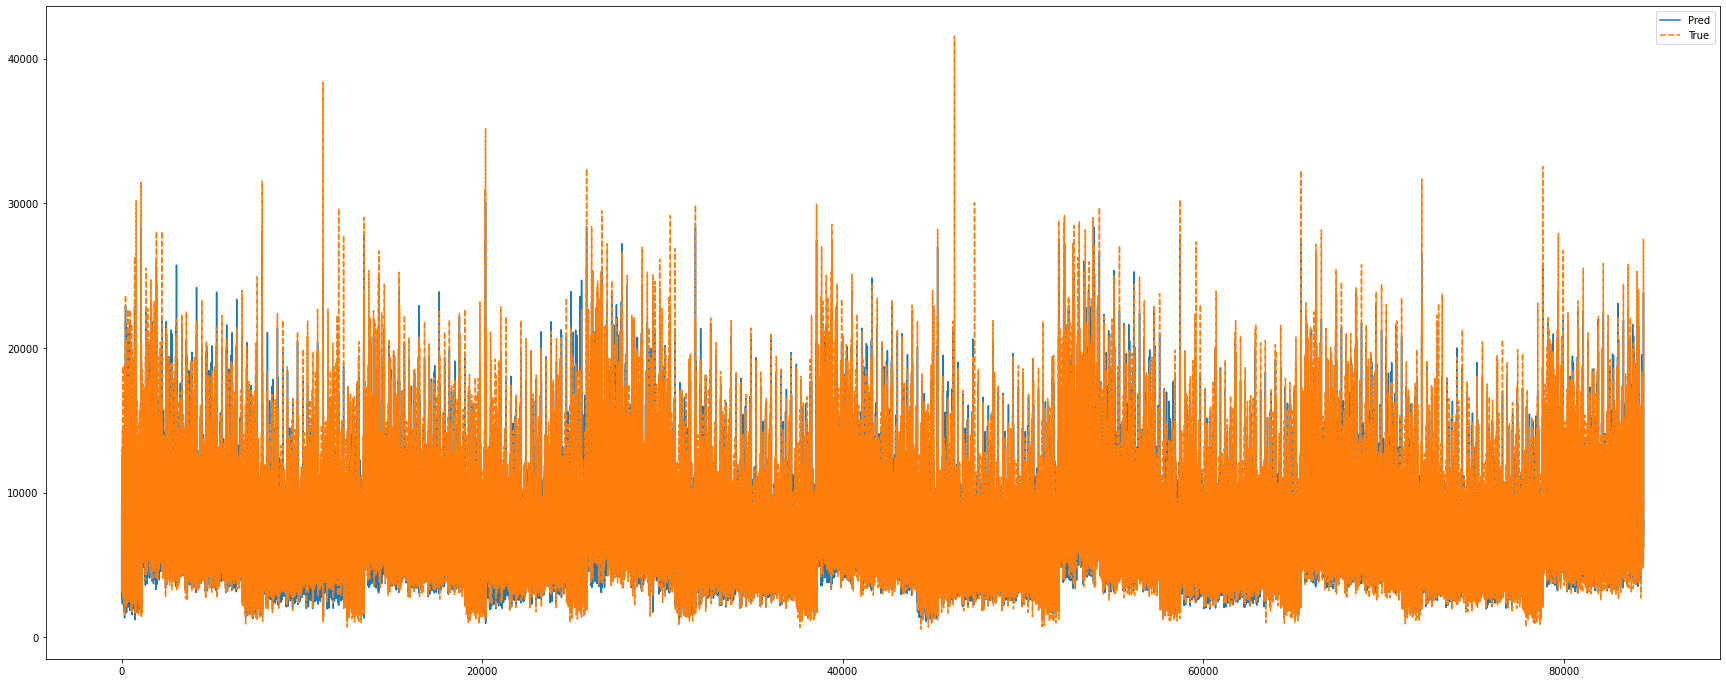

In [107]:
import seaborn as sns
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(30, 12))
g = sns.lineplot(data=result)
# _ = g.set_xticklabels(data_dis['CompetitionDistance'], rotation=90)  # 旋转 x 标签